# CNN using PyTorch

## Libraries used:

In [155]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## 2.1 Loading the FashionMNIST dataset

#### Download the dataset

In [156]:
trainSet = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                      transform=transforms.ToTensor())
testSet = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True,
                                      transform=transforms.ToTensor())

Make sure you turn on the GPU in Runtime setting, for a better performance.

In [157]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Get the train/test loader using DataLoader

 With batch size --> 100, and Shuffle is TRUE.

In [158]:
trainLoader = torch.utils.data.DataLoader(trainSet,batch_size=100,shuffle=True)
testLoader = torch.utils.data.DataLoader(testSet,batch_size=100,shuffle=True)

#### Creating a method to name the class for the label. 

example: 9 --> Ankle Boot

In [159]:
def outputLabel(label):
    outputMapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return outputMapping[input]

#### To show a data using matplotlib :

9


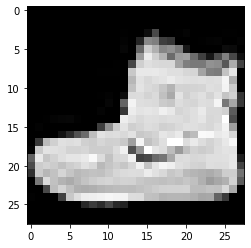

In [160]:
image, label = next(iter(trainSet))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

## 2.2 Implementing the Network

### Building the CNN class:
#### Model Class Name: FashionCNN
#### Layers: 2 sequential layers consist of:
             *  Convolution layer with kernal -> 3*3, padding = 1 (1st layer) & padding = 0 (2nd layer).
             *  Stride of 1 in both the layer
             *  Activation function: Relu
             *  All the functionaltiy is given in forward method that defines the forward pass of CNN.
             *  Output:
                     1.  1st Conv later:    input: 28 * 28 * 3   and  Output : 28 * 28 * 32.
                     2.  Max pooling layer: input: 28 * 28 * 32  and Output:  14 * 14 * 32.
                     3.  2nd Conv layer:    input : 14 * 14 * 32 and output: 12 * 12 * 64
                     4.  2nd Max Pooling layer : 12 * 12 * 64, output: 6 * 6 * 64.

#### At last fully connected layer has 10 output features for 10 types of clothes.


In [161]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

### Define CNN by using different architecture to construct model

Take a look of the chosen model:

In [ ]:
model = NeuralNetwork()
model.to(device)
#print(model)

Firstly, define the learnin rate:

In [163]:
learningRate = 0.001

Secondly, choose the optimizer in torch. First one we used, is ADAM:

In [149]:
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

The second optimizer we used is SGD:

(Note, you only need to run either the code above or the following one.

In [164]:
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, momentum=0.9)

## 2.3 Predicting


Let us start training the network with chosen architecture and optimizer, then test it on the testing dataset

In [165]:
error = nn.CrossEntropyLoss()
numEpochs = 15
count = 0
# Lists for visualization of loss and accuracy 
lossList = []
iterationList = []
accuracyList = []

# List classwise accuracy
predictionsList = []
labelsList = []

for epoch in range(numEpochs):
    for images, labels in trainLoader:
        # Transfering the images and labels to GPU(if available)
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Here is --> Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters (Adam Algorithm)
        optimizer.step()
    
        count += 1
    
    # Let us start testing the model:
    
        if not (count % 50):    
            total = 0
            correct = 0
        
            for images, labels in testLoader:
                images, labels = images.to(device), labels.to(device)
                labelsList.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictionsList.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            accuracy = correct * 1.0 / total
            lossList.append(loss.data)
            iterationList.append(count)
            accuracyList.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {:.3f}, Accuracy: {:.2%}".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.265, Accuracy: 86.36%
Iteration: 1000, Loss: 0.150, Accuracy: 88.40%
Iteration: 1500, Loss: 0.326, Accuracy: 89.72%
Iteration: 2000, Loss: 0.320, Accuracy: 90.50%
Iteration: 2500, Loss: 0.191, Accuracy: 90.32%
Iteration: 3000, Loss: 0.261, Accuracy: 90.05%
Iteration: 3500, Loss: 0.337, Accuracy: 90.77%
Iteration: 4000, Loss: 0.233, Accuracy: 90.64%
Iteration: 4500, Loss: 0.222, Accuracy: 90.64%
Iteration: 5000, Loss: 0.110, Accuracy: 90.47%
Iteration: 5500, Loss: 0.135, Accuracy: 91.72%
Iteration: 6000, Loss: 0.142, Accuracy: 90.32%
Iteration: 6500, Loss: 0.182, Accuracy: 90.73%
Iteration: 7000, Loss: 0.185, Accuracy: 91.04%
Iteration: 7500, Loss: 0.140, Accuracy: 91.18%
Iteration: 8000, Loss: 0.127, Accuracy: 90.62%
Iteration: 8500, Loss: 0.084, Accuracy: 91.31%
Iteration: 9000, Loss: 0.085, Accuracy: 91.31%


Plot the loss in iterations:

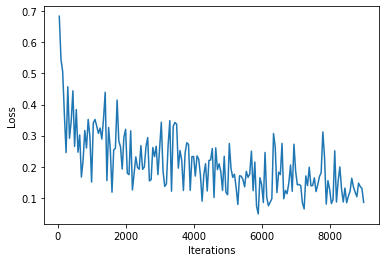

In [168]:
plt.plot(iterationList, lossList)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

Plot the accuracy in iterations:

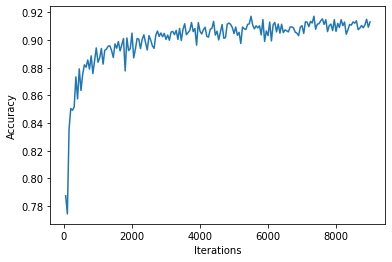

In [169]:
plt.plot(iterationList, accuracyList)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.show()

### Test

In [170]:
model.eval()
correct = 0
for images, labels in testLoader:
    with torch.no_grad(): # so that computation graph history is not stored
        images, labels = images.to(device), labels.to(device) # send tensors to GPU
        outputs = model(images)
        predictions = outputs.data.max(1)[1]
        correct += predictions.eq(labels.data).sum()
        
print('Test set accuracy: {:.2f}%'.format(100.0 * correct / len(testLoader.dataset)))

Test set accuracy: 91.46%


Auxillary: Getting the accuracy with respect to each classification in the MINST Dataset

In [171]:
classCorrect = [0. for _ in range(10)]
totalCorrect = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in testLoader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            classCorrect[label] += c[i].item()
            totalCorrect[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(outputLabel(i), classCorrect[i] * 100 / totalCorrect[i]))

Accuracy of T-shirt/Top: 82.40%
Accuracy of Trouser: 98.50%
Accuracy of Pullover: 84.60%
Accuracy of Dress: 93.90%
Accuracy of Coat: 87.10%
Accuracy of Sandal: 98.00%
Accuracy of Shirt: 77.60%
Accuracy of Sneaker: 97.80%
Accuracy of Bag: 97.60%
Accuracy of Ankle Boot: 97.10%


Among 10 categories, Bag has the highest prediction accuracy, and Shirt has the lowest.

In [ ]:
def train(dataloader, model, error, optimizer):
    size = len(dataloader.dataset)
    model.train() #to know the size of the model i have
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        pred = model(X)
        loss = error(pred,y)#calculate loss function(predicted, actual)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print("Loss ", loss, " Current ", batch, " of ", size/64)

def test(dataloader, model, error):
    size = len(dataloader.dataset) 
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += error(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        #print("Accuracy ", 100*correct, " % "

In [ ]:
epoches=1
for t in range(epoches):
    train(trainLoader, model, error, optimizer)
    test(testLoader, model, error)


In [ ]:
### Method to predict using the model


def pred_image(images, model):
    xb = to_device(image.unsqueeze(0), device)l
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]


images, labels = testSet[0]
print('Predicted:', pred_image(images, model),' Actual:', dataset.classes[label])

Predicted: Trouser  Actual: Dress

### Performance metrics

In [ ]:
actual=[]
predicted=[]

for i in range(10):
    images, labels = testSet[i]
    a=dataset.classes[labels]
    b=predict_image(images, model)
    if a == 'T-shirt/Top':
        actual.append(1)
    elif a == 'Trouser':
        actual.append(2)
    elif a == 'Pullover':
        actual.append(3)
    elif a == 'Dress':
        actual.append(4)
    elif a == 'Coat':
        actual.append(5)
    elif a == 'Sandal':
        actual.append(6)
    elif a == 'Shirt':
        actual.append(7)
    elif a == 'Sneaker':
        actual.append(8)
    elif a == 'Bag':
        actual.append(9)
    else:
        actual.append(10)
        
    if a == 'T-shirt/Top':
        predicted.append(1)
    elif a == 'Trouser':
        predicted.append(2)
    elif a == 'Pullover':
        predicted.append(3)
    elif a == 'Dress':
        predicted.append(4)
    elif a == 'Coat':
        predicted.append(5)
    elif a == 'Sandal':
        predicted.append(6)
    elif a == 'Shirt':
        Predicted.append(7)
    elif a == 'Sneaker':
        predicted.append(8)
    elif a == 'Bag':
        predicted.append(9)
    else:
        predicted.append(10)



### Performance Metrics


In [ ]:
from torchmetrics import Accuracy
from torchmetrics.functional import auc
from torchmetrics import Precision
from torchmetrics import Recall
from torchmetrics import ROC

real = torch.tensor(actual)
predicted = torch.tensor(predicted)
accuracy = Accuracy()
x=accuracy(predicted, real)
print("The Accuracy is :",accuracy(predicted, real).item())
print("The AUC is :",auc(predicted, real).item())
precision = Precision()
print("The Precision is :",precision(predicted, real).item())
recall = Recall()
print("The Precision is :",recall(predicted, real).item())
roc = ROC(pos_label=1)
fpr, tpr, thresholds = roc(predicted, real)
print("The ROC is :",recall(predicted, real).item())
print("The TPR is :",tpr.tolist())
print("The FPR is :",fpr.tolist())



The Accuracy is : 0.0

The AUC is : 0.0

The Precision is : 1.0

The Precision is : 0.0

The ROC is : 1.0

The TPR is : [0, 0]

The FPR is : [0.0, 1.0]

### Conclusion

The CNN Architecture defined according to the experiment, has a little bit more smooth loss curve and more stable. For the Architecture, ADAM predicts the accuracy faster. Although, SGD is more stable in loss calculation.
